# Dataset Exploration

To start off with, lets load in the tweet dataset and analyse its contents.

The following cell downloads the dataset from the web and extracts it:

In [ ]:
!rm -rf data
!mkdir -p data
!wget https://github.com/ghomasHudson/text-mining-demos-workshop/raw/main/disaster_tweets.zip -O data/data.zip
!unzip -j data/data.zip -d data
!rm data/data.zip

--2024-01-21 20:16:38--  https://github.com/ghomasHudson/text-mining-demos-workshop/raw/main/disaster_tweets.zip
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ghomasHudson/text-mining-demos-workshop/main/disaster_tweets.zip [following]
--2024-01-21 20:16:38--  https://raw.githubusercontent.com/ghomasHudson/text-mining-demos-workshop/main/disaster_tweets.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 410737 (401K) [application/zip]
Saving to: ‘data/data.zip’

data/data.zip       100%[===================>] 401.11K  --.-KB/s    in 0.01s   

2024-01-21 20:16:38 (31.0 MB/s) - ‘data/data.zip’ s

The data is structured in 2 main files: `data/train.csv` and `data/test.csv`, In later notebooks, we'll train models on the first and evaluate them on the second.

For now, lets use the pandas library to load the `data/train.csv` into this notebook:

In [ ]:
import pandas as pd
train_df = pd.read_csv("data/train.csv")

train_df.sample(5)

,id,keyword,location,text,target
3363,4814,evacuation,NaN,FAAN orders evacuation of abandoned aircraft a...,0
7444,10655,wounds,"Rutherfordton, NC",Help yourself or those you love who suffer fro...,0
58,82,ablaze,hollywoodland,They sky was ablaze tonight in Los Angeles. I'...,0
97,139,accident,"Hagerstown, MD",#BREAKING: there was a deadly motorcycle car a...,1
1364,1967,burning%20buildings,"Tucson, Arizona",You picture buildings burning to the ground fr...,1


We can see that the table has 5 columns, column "text" contains the tweet and column "target" indicates whether the tweet is refering to a natural disaster or not - 1 for disaster, 0 for non-disaster.

## Most Common Words

Lets examine what the most common words are in each class:

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


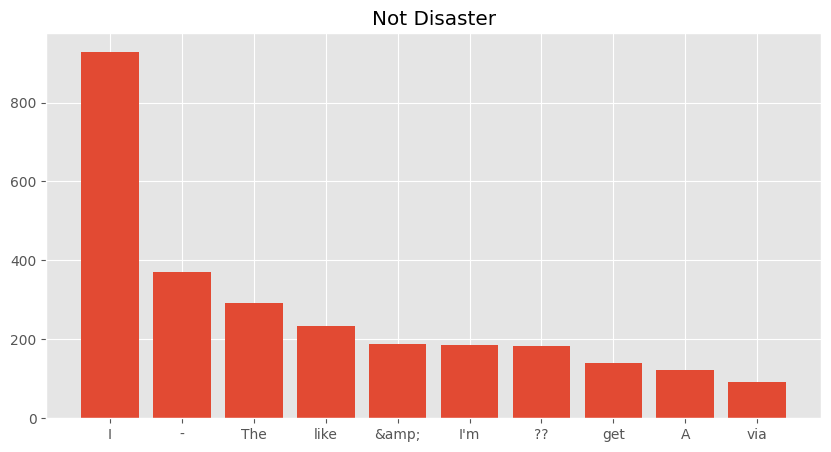

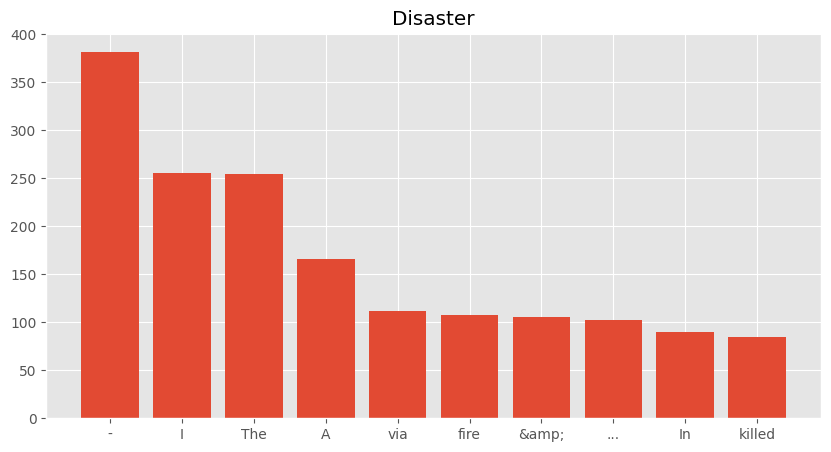

In [ ]:
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')


import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop = set(stopwords.words('english'))

def plot_most_common(data, label, top_n=10, title="Most Common"):

  # Get a list of all the words in the dataset
  words = []
  for x in data.loc[data["target"] == label, 'text'].str.split():
    for i in x:
      if i not in stop:
        words.append(i)

  # Turn this into a count of each word
  counts = defaultdict(int)
  for word in words:
    counts[word] += 1

  top_words = sorted(counts.items(), key=lambda x:x[1], reverse=True)[:top_n]

  # Plot
  x,y = zip(*top_words)
  plt.figure(figsize=(10,5))
  plt.title(title)
  plt.bar(x, y)


plot_most_common(train_df, 0, title="Not Disaster")
plot_most_common(train_df, 1, title="Disaster")

As you can see this is not very useful. Lets clean things up a little. Lets first define a function to remove urls from the tweets:

In [ ]:
import re

def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub('', text)

example = 'This is my tweet: https://www.example.com/c/sample-link'
remove_URL(example)

'This is my tweet: '

Now lets apply it to the whole dataset

In [ ]:
train_df['text'] = train_df['text'].apply(lambda x: remove_URL(x))

Lets do the same things for html code:

In [ ]:
def remove_html(text):
    html = re.compile(r'<.*?>')
    return html.sub('', text)


example = """<div>
<h1>Real or Fake</h1>
<p>Sentence </p>
<a href="https://www.example.com/c/sample-link">link text</a>
</div>"""
print(remove_html(example))


Real or Fake
Sentence 
link text



In [ ]:
train_df['text'] = train_df['text'].apply(lambda x: remove_html(x))

And emojis:

In [ ]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)

    return emoji_pattern.sub(r'', text)

remove_emoji("Omg another Earthquake 😔😔")

'Omg another Earthquake '

In [ ]:
train_df['text'] = train_df['text'].apply(lambda x: remove_emoji(x))

And punctuation:

In [ ]:
import string
def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)


example = "I am #king"
print(remove_punct(example))

I am king


In [ ]:
train_df['text'] = train_df['text'].apply(lambda x: remove_punct(x))

Now lets try it again:

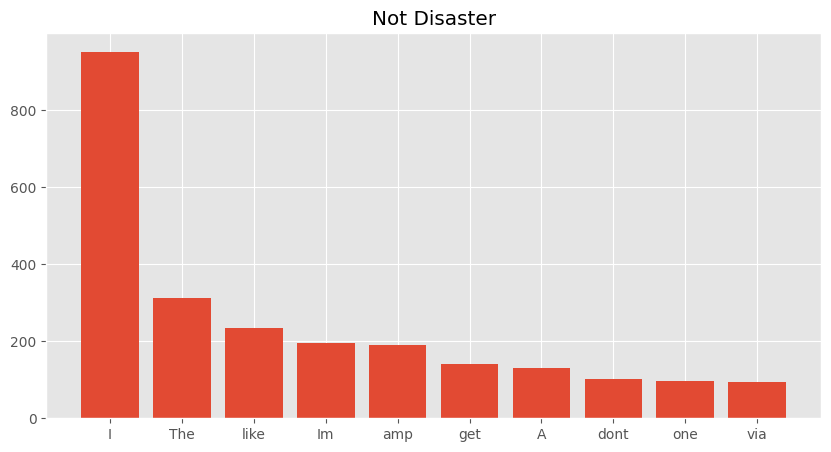

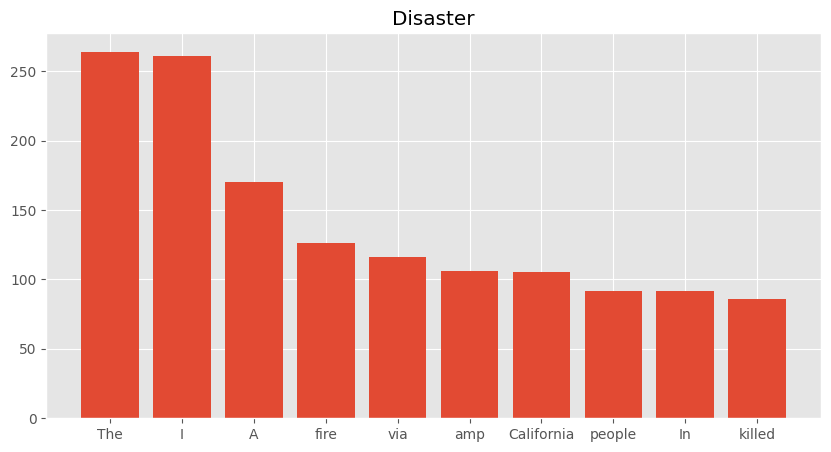

In [ ]:
plot_most_common(train_df, 0, title="Not Disaster")
plot_most_common(train_df, 1, title="Disaster")

# Lemmitization

Next we use lemmitization. This turns multiple forms of words e.g. "walking" "walker", "walks" into the single stem -> "walk".

In [ ]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
nltk.download('punkt')
nltk.download('wordnet')

keywords = train_df.keyword.unique()[1:]
keywords = list(map(lambda x: x.replace('%20', ' '), keywords))

wnl = WordNetLemmatizer()

def lemmatize_sentence(sentence):
    sentence_words = sentence.split(' ')
    new_sentence_words = list()

    for sentence_word in sentence_words:
        sentence_word = sentence_word.replace('#', '')
        new_sentence_word = wnl.lemmatize(sentence_word.lower(), wordnet.VERB)
        new_sentence_words.append(new_sentence_word)

    new_sentence = ' '.join(new_sentence_words)
    new_sentence = new_sentence.strip()

    return new_sentence

train_df['text'] = train_df['text'].apply(lambda x: lemmatize_sentence(x))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


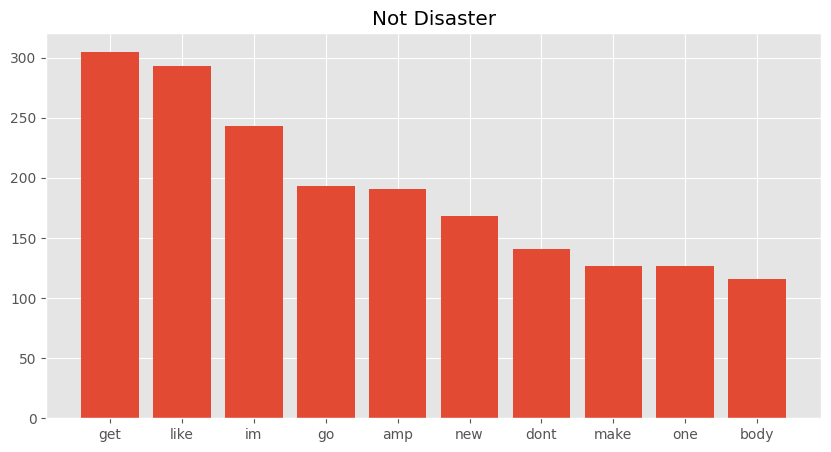

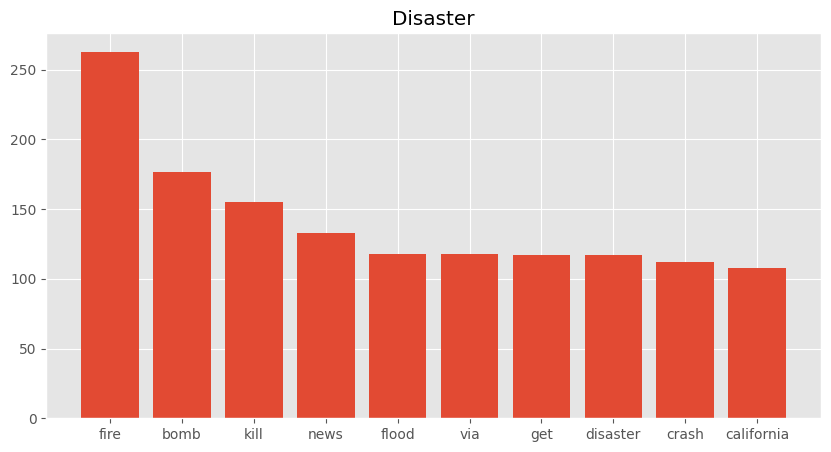

In [ ]:
plot_most_common(train_df, 0, title="Not Disaster")
plot_most_common(train_df, 1, title="Disaster")

# Additional Exercises

In each notebook I've added some additional exercises to suggest what you might want to try next.

1. Try plotting a wordcloud using the [wordcloud library](https://github.com/amueller/word_cloud). This gives you a better overall picture of the dataset.
2. Can you remove html entities such as &amp? Or should you decode them?
3. Try analysing one of your own datasets.